In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import pathlib
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:

# Define input image size and number of classes
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 10  # Replace with actual number of classes
BATCH_SIZE = 32
EPOCHS = 10  # Number of epochs for each fold


In [3]:
# Assuming data directory path setup (update this based on your actual directory structure)
dataset_url = "https://storage.googleapis.com/example_imagess/train.tar.gz"
data_dir = tf.keras.utils.get_file('train.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
class_names = sorted(os.listdir(data_dir))
X = []  # Placeholder for images
y = []  # Placeholder for labels


611809929/611809929 [==============================] - 190s 0us/step


In [4]:
# Set up K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
# Loading images and labels
for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        X.append(img_array)
        y.append(idx)  # Assuming class indices correspond to class_names

In [6]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Find and replace values equal to or greater than NUM_CLASSES
invalid_indices = np.where(y >= NUM_CLASSES)
y[invalid_indices] = NUM_CLASSES - 1  # Replace with the highest valid class index

# Convert labels to categorical format
y = tf.keras.utils.to_categorical(y, NUM_CLASSES)

In [7]:
# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print(f"Training fold {fold + 1}...")

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...


In [8]:
   # Split data for current fold
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

In [9]:
    # Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Use flow for array-based data
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

In [11]:
# Load EfficientNet model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False  # Freeze base layers



16705208/16705208 [==============================] - 7s 0us/step


In [12]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)


In [13]:
# Create model
model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
 # Train model on current fold
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)
 # Optional: Unfreeze some layers for fine-tuning
for layer in base_model.layers[-10:]:
        layer.trainable = True
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/10


979/979 [==============================] - 513s 519ms/step - loss: 1.6304 - accuracy: 0.5748 - val_loss: 1.6270 - val_accuracy: 0.5723
Epoch 2/10
979/979 [==============================] - 412s 420ms/step - loss: 1.6253 - accuracy: 0.5755 - val_loss: 1.6244 - val_accuracy: 0.5723
Epoch 3/10
979/979 [==============================] - 383s 391ms/step - loss: 1.6212 - accuracy: 0.5755 - val_loss: 1.6304 - val_accuracy: 0.5723
Epoch 4/10
979/979 [==============================] - 385s 393ms/step - loss: 1.6198 - accuracy: 0.5755 - val_loss: 1.6245 - val_accuracy: 0.5723
Epoch 5/10
979/979 [==============================] - 368s 376ms/step - loss: 1.6194 - accuracy: 0.5755 - val_loss: 1.6251 - val_accuracy: 0.5723
Epoch 6/10
979/979 [==============================] - 366s 374ms/step - loss: 1.6183 - accuracy: 0.5755 - val_loss: 1.6251 - val_accuracy: 0.5723
Epoch 7/10
979/979 [==============================] - 367s 375ms/step - loss: 1.6183 - accuracy: 0.5755 - val_loss: 1.6455

In [15]:
 # Continue training for fine-tuning
model.fit(train_generator, validation_data=val_generator, epochs=5)

# After each fold, you can save metrics for evaluation
# e.g., accuracy, val_accuracy = model.evaluate(val_generator)
print(f"Completed fold {fold + 1}")


Epoch 1/5
979/979 [==============================] - 425s 431ms/step - loss: 1.7821 - accuracy: 0.5219 - val_loss: 1.6252 - val_accuracy: 0.5723
Epoch 2/5
979/979 [==============================] - 377s 385ms/step - loss: 1.6158 - accuracy: 0.5755 - val_loss: 1.6198 - val_accuracy: 0.5723
Epoch 3/5
979/979 [==============================] - 374s 382ms/step - loss: 1.6137 - accuracy: 0.5755 - val_loss: 1.6203 - val_accuracy: 0.5723
Epoch 4/5
979/979 [==============================] - 434s 443ms/step - loss: 1.6112 - accuracy: 0.5755 - val_loss: 1.6153 - val_accuracy: 0.5723
Epoch 5/5
979/979 [==============================] - 513s 524ms/step - loss: 1.6111 - accuracy: 0.5755 - val_loss: 1.6141 - val_accuracy: 0.5723
Completed fold 5


In [84]:
from sklearn.metrics import classification_report
import numpy as np

# Define number of folds for cross-validation
num_folds = 5

# Loop through each fold
for fold in range(num_folds):
    # Continue training the model for the fold
    model.fit(train_generator, validation_data=val_generator, epochs=5)
    
    # Get predictions on the validation data
    val_predictions = model.predict(val_generator)
    val_pred_classes = np.argmax(val_predictions, axis=1)  # Predicted class labels

    # Get true class labels from the validation data
    val_true_classes = val_generator.classes  # Assuming val_generator provides true labels

    # Generate classification report
    report = classification_report(val_true_classes, val_pred_classes, target_names=val_generator.class_indices.keys())
    print(f"Classification report for fold {fold + 1}:\n{report}")
    
    # Print completed fold
    print(f"Completed fold {fold + 1}")


Epoch 1/5
979/979 [==============================] - 40s 41ms/step - loss: 0.0171 - accuracy: 0.9952 - val_loss: 0.3764 - val_accuracy: 0.9409
Epoch 2/5
979/979 [==============================] - 39s 40ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.3006 - val_accuracy: 0.9493
Epoch 3/5
979/979 [==============================] - 44s 45ms/step - loss: 0.0222 - accuracy: 0.9941 - val_loss: 0.2714 - val_accuracy: 0.9558
Epoch 4/5
979/979 [==============================] - 53s 54ms/step - loss: 0.0148 - accuracy: 0.9955 - val_loss: 0.3050 - val_accuracy: 0.9519
Epoch 5/5
245/245 [==============================] - 5s 20ms/step
Classification report for fold 1:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.04      0.04      0.04       386
                                 Apple___Black_rot       0.05      0.04      0.05       356
                          Apple___Cedar_apple_rust 

 Sequential model training

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
import numpy as np
import os
import pathlib
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [87]:
# Define input image size
IMAGE_SIZE = (255, 255)
BATCH_SIZE = 64
EPOCHS = 15  # Number of epochs
NUM_FOLDS = 5  # Number of folds for cross-validation

In [88]:
# Assuming the dataset is stored in a tar.gz file
dataset_url = "https://storage.googleapis.com/example_imagess/train.tar.gz"
data_dir = tf.keras.utils.get_file('train.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [89]:
# Dynamically determine number of classes
class_names = sorted(os.listdir(data_dir))
NUM_CLASSES = len(class_names)  # Update NUM_CLASSES based on the dataset structure

In [90]:
# Prepare data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # To keep some validation data
)

# Collect all images and labels for K-Fold
all_images = []
all_labels = []

In [91]:
for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        all_images.append(img_path)
        all_labels.append(class_name)  # Use class names directly

# Convert to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

In [92]:
# K-Fold Cross Validation
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(all_images)):
    print(f"Training fold {fold + 1}...")

    # Create training and validation datasets for this fold
    train_images, val_images = all_images[train_idx], all_images[val_idx]
    train_labels, val_labels = all_labels[train_idx], all_labels[val_idx]

    # Define training and validation generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
        x_col='filename',
        y_col='class',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse'
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
        x_col='filename',
        y_col='class',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse'
    )

Training fold 1...
Found 31321 validated image filenames belonging to 21 classes.
Found 7831 validated image filenames belonging to 21 classes.
Training fold 2...
Found 31321 validated image filenames belonging to 21 classes.
Found 7831 validated image filenames belonging to 21 classes.
Training fold 3...
Found 31322 validated image filenames belonging to 21 classes.
Found 7830 validated image filenames belonging to 21 classes.
Training fold 4...
Found 31322 validated image filenames belonging to 21 classes.
Found 7830 validated image filenames belonging to 21 classes.
Training fold 5...
Found 31322 validated image filenames belonging to 21 classes.
Found 7830 validated image filenames belonging to 21 classes.


In [93]:
 # Define the model
model = models.Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_CLASSES)  # Keep NUM_CLASSES based on the number of unique class names
    ])

In [94]:
model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 255, 255, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 127, 127, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 31, 31, 64)       

In [95]:
 # Train the model
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

Epoch 1/15
490/490 [==============================] - 359s 731ms/step - loss: 0.7493 - accuracy: 0.7675 - val_loss: 0.3765 - val_accuracy: 0.8783
Epoch 2/15
490/490 [==============================] - 201s 410ms/step - loss: 0.2265 - accuracy: 0.9251 - val_loss: 0.2351 - val_accuracy: 0.9245
Epoch 3/15
490/490 [==============================] - 176s 358ms/step - loss: 0.1238 - accuracy: 0.9588 - val_loss: 0.2382 - val_accuracy: 0.9267
Epoch 4/15
490/490 [==============================] - 201s 410ms/step - loss: 0.0856 - accuracy: 0.9716 - val_loss: 0.2040 - val_accuracy: 0.9374
Epoch 5/15
490/490 [==============================] - 196s 400ms/step - loss: 0.0635 - accuracy: 0.9798 - val_loss: 0.2075 - val_accuracy: 0.9400
Epoch 6/15
490/490 [==============================] - 200s 408ms/step - loss: 0.0544 - accuracy: 0.9815 - val_loss: 0.1826 - val_accuracy: 0.9513
Epoch 7/15
490/490 [==============================] - 195s 399ms/step - loss: 0.0374 - accuracy: 0.9875 - val_loss: 0.1972 -

In [98]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define number of folds for cross-validation
num_folds = 5
accuracy_scores = []
all_true_labels = []
all_pred_labels = []

# Loop through each fold
for fold in range(num_folds):
    # Train the model on the current fold
    model.fit(train_generator, validation_data=val_generator, epochs=5)
    
    # Predict on the validation data for the current fold
    val_predictions = model.predict(val_generator)
    val_pred_classes = np.argmax(val_predictions, axis=1)  # Predicted class labels
    val_true_classes = val_generator.classes  # True class labels
    
    # Calculate accuracy for the current fold
    accuracy = accuracy_score(val_true_classes, val_pred_classes)
    accuracy_scores.append(accuracy)
    
    # Append predictions and true labels to overall lists
    all_true_labels.extend(val_true_classes)
    all_pred_labels.extend(val_pred_classes)
    
    # Print completed fold
    print(f"Completed fold {fold + 1} with accuracy: {accuracy:.4f}")

# Calculate the average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print(f"Average Accuracy across all folds: {average_accuracy:.4f}")

# Generate a final classification report using all predictions and labels
final_report = classification_report(all_true_labels, all_pred_labels, target_names=val_generator.class_indices.keys())
print("Final Classification Report:\n", final_report)


Epoch 1/5
490/490 [==============================] - 190s 387ms/step - loss: 0.0252 - accuracy: 0.9919 - val_loss: 0.2996 - val_accuracy: 0.9474
Epoch 2/5
490/490 [==============================] - 152s 309ms/step - loss: 0.0261 - accuracy: 0.9914 - val_loss: 0.3134 - val_accuracy: 0.9358
Epoch 3/5
490/490 [==============================] - 191s 389ms/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 0.2314 - val_accuracy: 0.9585
Epoch 4/5
490/490 [==============================] - 192s 391ms/step - loss: 0.0229 - accuracy: 0.9934 - val_loss: 0.2592 - val_accuracy: 0.9460
Epoch 5/5
123/123 [==============================] - 19s 150ms/step
Completed fold 1 with accuracy: 0.0517
Epoch 1/5
490/490 [==============================] - 188s 384ms/step - loss: 0.0250 - accuracy: 0.9923 - val_loss: 0.2949 - val_accuracy: 0.9531
Epoch 2/5
490/490 [==============================] - 194s 396ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.3308 - val_accuracy: 0.9404
Epoch 3/5
490/490 [====

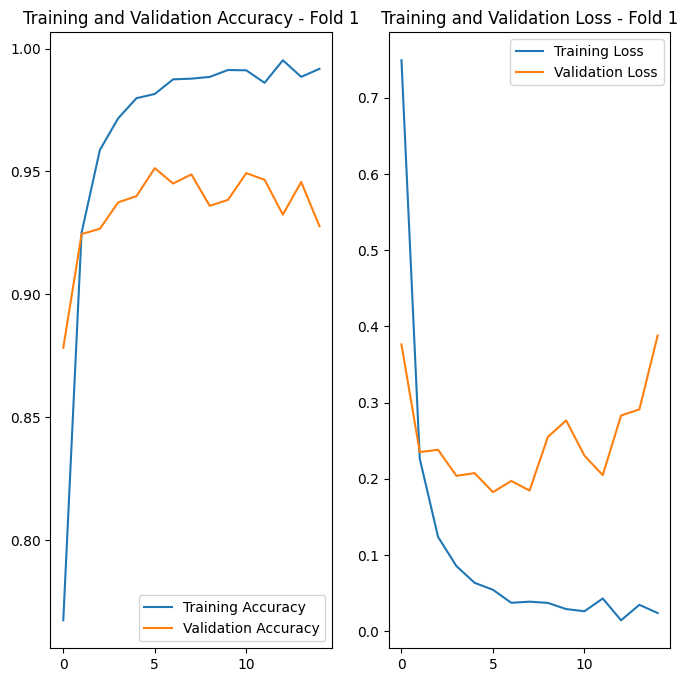

Completed fold 1


In [97]:
# Plotting the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Training and Validation Accuracy - Fold {fold + 1}')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Training and Validation Loss - Fold {fold + 1}')
plt.show()

print(f"Completed fold {fold + 1}")

In [79]:
val_generator.reset()
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

    # Generate classification report
print("Classification Report:")
print(classification_report(val_labels, predicted_classes, target_names=class_names))


245/245 [==============================] - 5s 21ms/step
Classification Report:


ValueError: Mix of label input types (string and number)